In [1]:
import tropycal.tracks as tracks
from useful_functions import create_genesis_grid_labels
import numpy as np
import xarray as xr
from scipy.ndimage import gaussian_filter
from scipy.ndimage import median_filter
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import skimage.measure as ms
import scipy.ndimage as nd

In [5]:
# # Time ranges for EVERYTHING desired
month_range = np.arange(6,12,1)
test_years = np.arange(2005,2021,1)
train_years = np.arange(1950,2005,1)
train_years = np.setdiff1d(train_years, np.arange(1971,1979,1))
Latitude=np.arange(0,80,2)
Longitude=np.arange(260,360,2)

# # Grab ibtracs data (uncomment this section if you want to recreate genesis (observed) labels, otherwise it is already saved)
# basin_dataset = tracks.TrackDataset(basin='north_atlantic',source='ibtracs',include_btk=True)

# # Create genesis labels from ibtracs data (slowest step)
# vmin=0
# print('Training Dataset')
# train_labels_predropped = create_genesis_grid_labels(month_range,train_years,vmin,basin_dataset)
# print('Testing Dataset')
# test_labels_predropped = create_genesis_grid_labels(month_range,test_years,vmin,basin_dataset)

# train_labels_predropped.unstack().to_netcdf("/glade/work/acheung/Initial_RF_Datasets/train_labels_predropped.nc")
# test_labels_predropped.unstack().to_netcdf("/glade/work/acheung/Initial_RF_Datasets/test_labels_predropped.nc")

--> Starting to read in ibtracs data
--> Completed reading in ibtracs data (5.37 seconds)
--> Starting to read in best track data
--> Completed reading in best track data (0.22 seconds)
Training Dataset


/glade/u/home/acheung/TC_Genesis_Index/Scripts/useful_functions.py:53: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  gen_by_month = szn_DF_starts.loc[str(dt(year=year_desired,
/glade/u/home/acheung/TC_Genesis_Index/Scripts/useful_functions.py:53: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  gen_by_month = szn_DF_starts.loc[str(dt(year=year_desired,
/glade/u/home/acheung/TC_Genesis_Index/Scripts/useful_functions.py:53: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  gen_by_month = szn_DF_starts.loc[str(dt(year=year_desired,
/glade/u/home/acheung/TC_Genesis_Index/Scripts/useful_functions.py:53: FutureWarning: Value based partial slicing on non-mon

Testing Dataset


/glade/u/home/acheung/TC_Genesis_Index/Scripts/useful_functions.py:53: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  gen_by_month = szn_DF_starts.loc[str(dt(year=year_desired,
/glade/u/home/acheung/TC_Genesis_Index/Scripts/useful_functions.py:53: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  gen_by_month = szn_DF_starts.loc[str(dt(year=year_desired,
/glade/u/home/acheung/TC_Genesis_Index/Scripts/useful_functions.py:53: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  gen_by_month = szn_DF_starts.loc[str(dt(year=year_desired,
/glade/u/home/acheung/TC_Genesis_Index/Scripts/useful_functions.py:53: FutureWarning: Value based partial slicing on non-mon

In [2]:
train_labels_predropped_read = xr.open_dataset("/glade/work/acheung/Initial_RF_Datasets/train_labels_predropped.nc")
train_labels_predropped = train_labels_predropped_read.stack(z=("Month","Latitude","Longitude","Year"))

test_labels_predropped_read = xr.open_dataset("/glade/work/acheung/Initial_RF_Datasets/test_labels_predropped.nc")
test_labels_predropped = test_labels_predropped_read.stack(z=("Month","Latitude","Longitude","Year"))

/glade/u/home/acheung/.conda/envs/snowflakes/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = super().pcolormesh(*args, **kwargs)


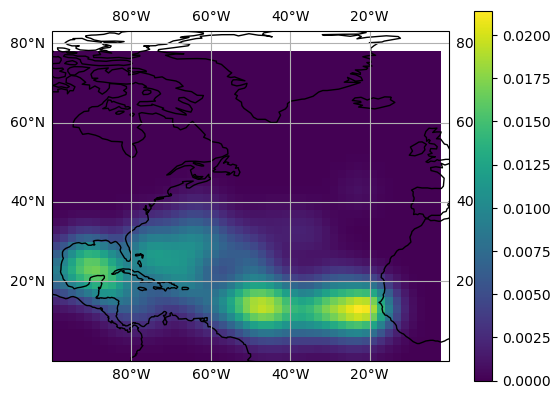

In [6]:
climo_month_label = train_labels_predropped_read.sel(Month=9).to_array()[0]
climo_mean_month_label = np.mean(climo_month_label,axis=2)
climo_filtered_month = gaussian_filter(climo_mean_month_label, sigma=2)
climo_filtered_month_with_coords = xr.DataArray(climo_filtered_month, coords=[climo_mean_month_label.coords['Latitude'],climo_mean_month_label.coords['Longitude']])

# Monthly Climatological Plot (Monthly Mean Performed)

plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.gridlines(draw_labels=True)
climo_filtered_month_plot = ax.pcolormesh(climo_filtered_month_with_coords.coords['Longitude'],
                                    climo_filtered_month_with_coords.coords['Latitude'],
                                    climo_filtered_month_with_coords,transform=ccrs.PlateCarree(),vmin=0)
ax.set_extent([-100, 0, 0, 80])
cbar = plt.colorbar(climo_filtered_month_plot)
plt.savefig('climo')


/glade/u/home/acheung/.conda/envs/snowflakes/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = super().pcolormesh(*args, **kwargs)


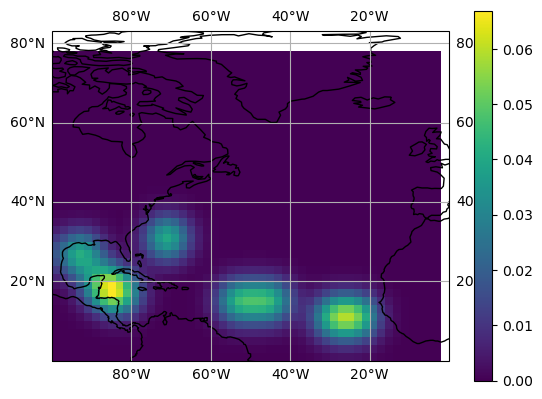

In [8]:
interval = 1 # pooling size (1 is no pooling)

trainlabelpoints_pooled = xr.DataArray(ms.block_reduce(train_labels_predropped_read.to_array()[0], (1,interval,interval,1),np.nansum),
             coords=[train_labels_predropped_read.coords['Month'],
                     train_labels_predropped_read.coords['Latitude'][::interval],
                    train_labels_predropped_read.coords['Longitude'][::interval],
                     train_labels_predropped_read.coords['Year']])

filtered = gaussian_filter(trainlabelpoints_pooled.sel(Month=9,Year=2000).astype(float),sigma=2)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.gridlines(draw_labels=True)
contourplot = ax.pcolormesh(train_labels_predropped_read.coords['Longitude'][::interval],
                           train_labels_predropped_read.coords['Latitude'][::interval],filtered,transform=ccrs.PlateCarree())
ax.set_extent([-100, 0, 0, 80])
cbar = plt.colorbar(contourplot)
plt.savefig('test')
# testlabelpoints_pooled_masked = testlabelpoints_pooled.where(isnan_pool != 0)

/glade/u/home/acheung/.conda/envs/snowflakes/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1785: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = super().pcolormesh(*args, **kwargs)


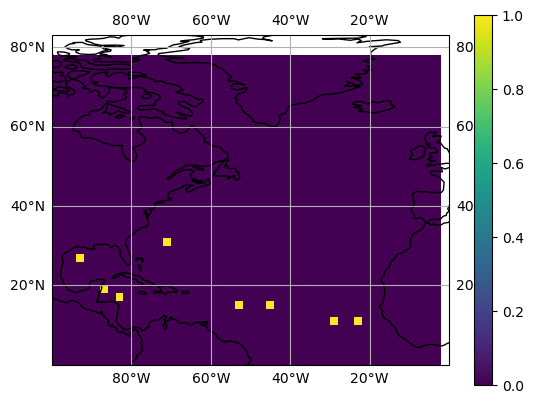

In [9]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.gridlines(draw_labels=True)
contourplot = ax.pcolormesh(train_labels_predropped_read.coords['Longitude'][::interval],
                           train_labels_predropped_read.coords['Latitude'][::interval],
                            train_labels_predropped_read.to_array()[0].sel(Month=9,Year=2000),transform=ccrs.PlateCarree())
ax.set_extent([-100, 0, 0, 80])
cbar = plt.colorbar(contourplot)
plt.savefig('gensislocs')